# Computer vision проект

## 1. Импорты

In [ ]:
!pip install torchvision
!pip install torchinfo
from typing import List
from torch.nn import functional as F
from torchinfo import summary
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import os
from pathlib import Path
from zipfile import ZipFile as zp

## Получаем и распаковываем файл с датасетом:

In [ ]:
path = Path('sample_data').parent
path_file = (path / 'drive' / 'MyDrive')
with zp(path_file / 'archive.zip', 'r') as zp:
  zp.extractall(path)

Также импортирую функции-помощники из репозитория

In [ ]:
if Path('helper_functions.py').is_file():
  print('already exists')
else:
  print('downloading')
  request = requests.get('https://github.com/ra1der03/helper_functions/raw/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

already exists


Структура загруженного с данными файла

In [ ]:
from helper_functions import walk_through_dir as wtd

wtd(path / 'flowers')

There are 1 directories and 0 images in 'flowers'.
There are 1 directories and 0 images in 'flowers/flowers'.
There are 3 directories and 0 images in 'flowers/flowers/flower_photos'.
There are 5 directories and 0 images in 'flowers/flowers/flower_photos/test'.
There are 0 directories and 10 images in 'flowers/flowers/flower_photos/test/tulips'.
There are 0 directories and 10 images in 'flowers/flowers/flower_photos/test/sunflowers'.
There are 0 directories and 10 images in 'flowers/flowers/flower_photos/test/daisy'.
There are 0 directories and 10 images in 'flowers/flowers/flower_photos/test/dandelion'.
There are 0 directories and 10 images in 'flowers/flowers/flower_photos/test/roses'.
There are 5 directories and 0 images in 'flowers/flowers/flower_photos/validation'.
There are 0 directories and 16 images in 'flowers/flowers/flower_photos/validation/tulips'.
There are 0 directories and 16 images in 'flowers/flowers/flower_photos/validation/sunflowers'.
There are 0 directories and 16 i

Разделение путей к папкам с объектами по выборкам

In [ ]:
train_path = path / 'flowers' / 'flowers' / 'flower_photos' / 'train'
test_path = path / 'flowers' / 'flowers' / 'flower_photos' / 'test'
validate_path = path / 'flowers' / 'flowers' / 'flower_photos' / 'validation'
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
path = path / 'flowers'
path

PosixPath('flowers')

## 3. Ознакомление с данными

flowers/flowers/flower_photos/train/tulips/16485607329_e66d5960bc_m.jpg
      tulips
      240
      180


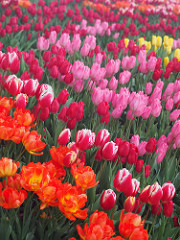

In [ ]:
import random
from PIL import Image
# random.seed(42)
image_path_list = list(path.glob("*/*/*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f'''{random_image_path}
      {image_class}
      {img.height}
      {img.width}''')
img

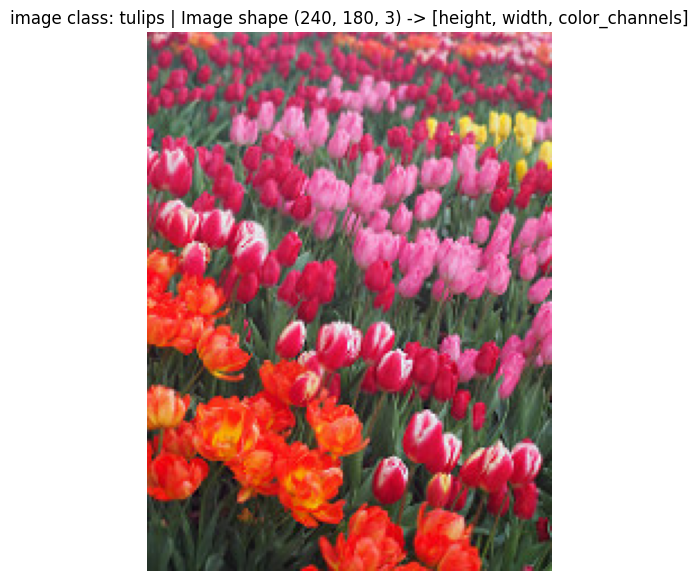

In [ ]:
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f'image class: {image_class} | Image shape {img_as_array.shape} -> [height, width, color_channels]')
plt.axis(False);

## 4. Разделяем выборки, формируя data_transforms и dataloaders

Создаем transforms, соответствующие модели используя веса, полученные импортом из torchvision

In [ ]:
from torch.utils.data import DataLoader

weights=torchvision.models.ResNet50_Weights.DEFAULT

transform_train = weights.transforms()


data_transforms = {
    'validation':
    transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    }
transform_train(img).shape

torch.Size([3, 224, 224])

Визуализация измененных под модель изображений

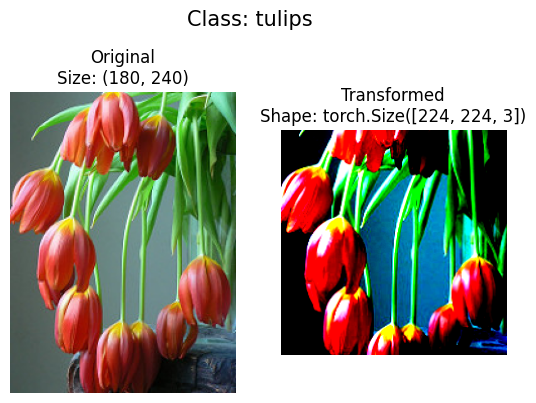

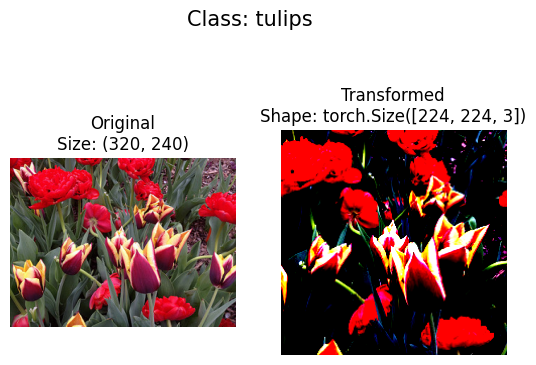

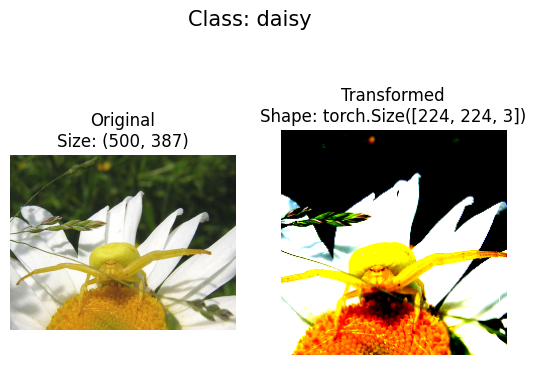

In [ ]:
random.seed(42)
random_image_paths = random.sample(image_path_list, 3, )
for image_path in random_image_paths:
  with Image.open(image_path) as f:
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(f)
    ax[0].set_title(f'Original\nSize: {f.size}')
    ax[0].axis(False)
    transformed_image = transform_train(f).permute(1, 2, 0) # change order of dims to set color_channel last
    ax[1].imshow(transformed_image)
    ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
    ax[1].axis('off')

    fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=15)


Разбиение на датасеты по выборкам

In [ ]:
image_datasets = {'train':
            datasets.ImageFolder(root=train_path,
                                         transform=transform_train),
            'validation': datasets.ImageFolder(root=test_path,
                                         transform=data_transforms['validation']),
            'test': datasets.ImageFolder(root=validate_path,
                                         transform=data_transforms['validation'])}

Создаём словарь с Dataloader по выборкам

In [ ]:
from torch.utils.data import DataLoader

dataloaders = {'train':
    DataLoader(dataset=image_datasets['train'],
                              shuffle=True,
                              batch_size=32,
                              num_workers=os.cpu_count()),
               'validation': DataLoader(dataset=image_datasets['validation'],
                              shuffle=False,
                              batch_size=32,
                              num_workers=os.cpu_count()),
               'test': DataLoader(dataset=image_datasets['test'],
                                 shuffle=False,
                                 batch_size=32,
                                 num_workers=os.cpu_count())}

## 5. Получаем модель и инициализируем

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torchvision.models.resnet50(weights=weights).to(device)

Отключаем обучение на глубинных слоях и меняем классификатор под наш датасет (по количеству классов)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for param in model.parameters():
  param.requires_grad = False

output_shape = len(class_names)

model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 5)).to(device)

Смотрим блоки и слои модели, их "тренируемость" и входные-выходные размеры

In [ ]:
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

Определяем optimizer и функцию потерь

In [ ]:
from helper_functions import accuracy_fn as acc
from helper_functions import print_train_time as ptt
from timeit import default_timer as timer

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
print(f'''Длина тренировочного dataloader: {len(dataloaders['train'])}
Длина валидационного dataloader: {len(dataloaders['validation'])}
Длина тестового dataloader: {len(dataloaders['test'])}''')

Длина тренировочного dataloader: 111
Длина валидационного dataloader: 2
Длина тестового dataloader: 3


## 6. Проводим тренировочно-валидационный цикл, замеряем результаты

Функция цикла:

In [ ]:
results = {"train_loss": [],
        "train_acc": [],
        "validation_loss": [],
        "validation_acc": []
    }

def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            print(f'{phase} loss: {epoch_loss.item():.4f}, acc: {epoch_acc.item():.4f}\n')
            results[phase+'_loss'].append(epoch_loss.item())
            results[phase+'_acc'].append(epoch_acc.item())

    return model, results

Запуск цикла:

In [ ]:
model_trained, results = train_model(model, loss_fn, optimizer, num_epochs=7)

Epoch 1/7
----------
train loss: 0.5192, acc: 0.8398

validation loss: 0.4087, acc: 0.9000

Epoch 2/7
----------
train loss: 0.2028, acc: 0.9322

validation loss: 0.3611, acc: 0.8800

Epoch 3/7
----------
train loss: 0.1312, acc: 0.9619

validation loss: 0.3779, acc: 0.9000

Epoch 4/7
----------
train loss: 0.0941, acc: 0.9726

validation loss: 0.3447, acc: 0.9400

Epoch 5/7
----------
train loss: 0.0652, acc: 0.9831

validation loss: 0.4002, acc: 0.9000

Epoch 6/7
----------
train loss: 0.0600, acc: 0.9805

validation loss: 0.3616, acc: 0.9000

Epoch 7/7
----------
train loss: 0.0383, acc: 0.9910

validation loss: 0.4159, acc: 0.9600



Функция визуализации процесса обучения по тренировочным\тестовым потерям\точности:

In [ ]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "validation_loss": [...],
             "validation_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["validation_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["validation_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="validation_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="validation_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

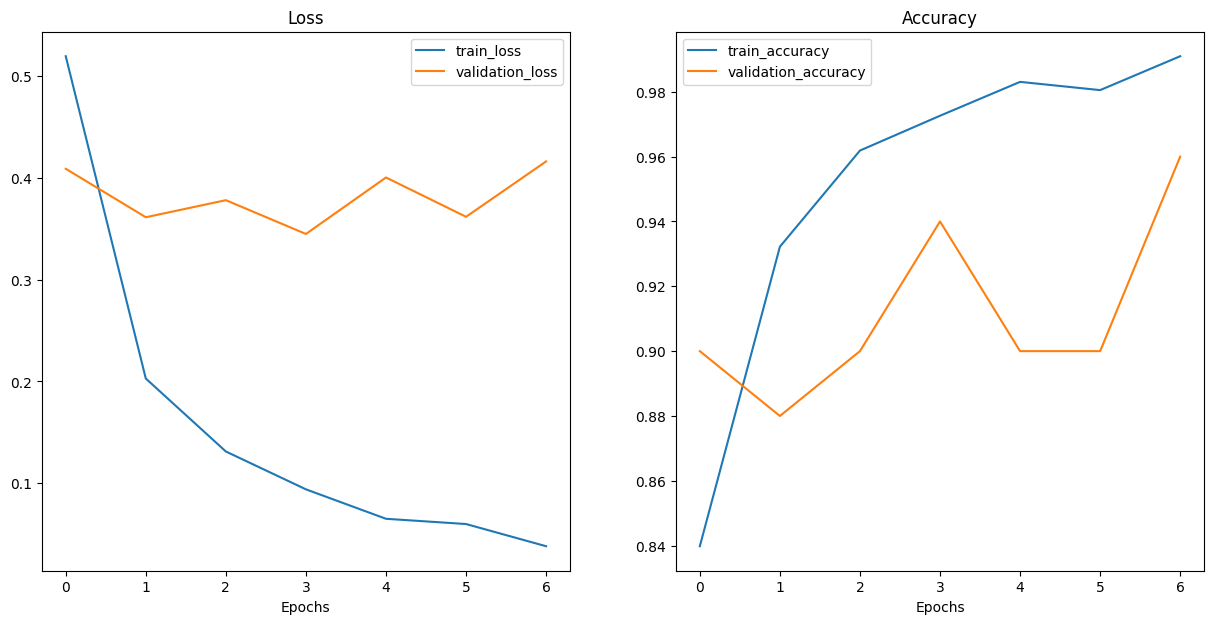

In [ ]:
plot_loss_curves(results)

Сохраняем модель в файле

In [ ]:
path_model = Path('sample_data')
torch.save(model_trained.state_dict(), path_model.parent / 'weights.h7')

Пробуем сразу же ими воспользоваться

In [ ]:
model = torchvision.models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 5)).to(device)

model.load_state_dict(torch.load(path_model.parent / 'weights.h7'))

## 7. Наглядная оценка работы модели на тестовой выборке

Случайно выбранные изображения преобразовываем для модели, делаем на них предсказания и выводим с фактическим классом изображения:

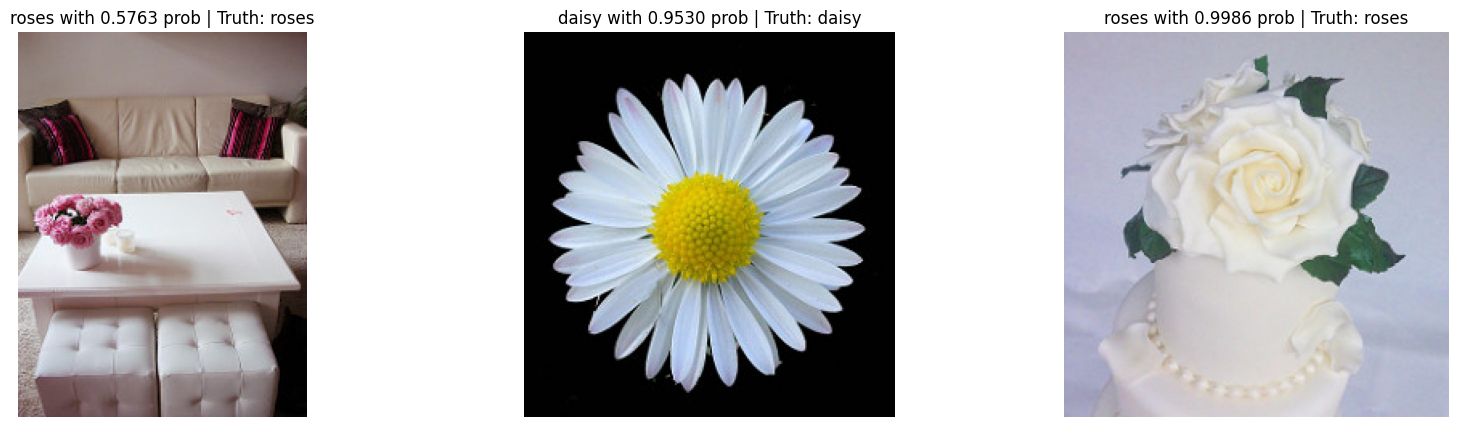

In [ ]:
image_path_list = list(validate_path.glob("*/*.jpg"))
random_image_path_list = []

for i in range(3):
  r = torch.randint(1, len(image_path_list), size=(1,))
  random_image_path_list.append(image_path_list[r])

img_list = [Image.open(img_path) for img_path in random_image_path_list]
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1)


fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title(f"{class_names[torch.argmax(pred_probs[i])]} with {(pred_probs[i][torch.argmax(pred_probs[i])]):.4f} prob | Truth: {random_image_path_list[i].parent.stem}")
    ax.imshow(img)
